# X-Ray Image Labelling & Reporting
## Data Exploration & Feature Engineering

**`Team AKAKI!` | `Minerva University`**

**`Goals/Guiding Questions for Exploration:`**
- What are the right dimensions for the images, will PCA be necessary (or relevant/valuable)?
- Data exploration on findings. What are the most common words (wordcloud? most common phrases etc.). This can be done for different columns (e.g. Indication, Findings/Impressions)
- Think about incorporating and therefore streamlining synonyms to technical words. 
- Can you identify any features that we should engineer from your analysis?


In this notebook, we conduct an exploration of the preprocessed dataset. We looked at the number of images and reports we have and identified that there are fewer reports than images, which meant that some reports had more than images associated with them. We offered some samples to show how the images and the reports look like. Moreover, we attempted to get an overall understanding of the content of those reports; thus, we generated word clouds, which give visual representations of words that appear more frequently.

### 1. Library Importation

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud

### 2. Load the report data

In [ ]:
full_df = pd.read_csv("../data/interim/full_cleaned_data.csv")
frontal_df = pd.read_csv('../data/interim/full_frontal.csv')
lateral_df = pd.read_csv('../data/interim/full_lateral.csv')

### 3. Quick preview & info

In this section, we extract some basic information from the dataset such as the number of images and reports. 

In [ ]:
full_df.head()

,uid,MeSH,Problems,findings,impression,filename,projection,caption
0,1,normal,normal,the cardiac silhouette and mediastinum size ar...,normal chest,1_IM-0001-4001.dcm.png,Frontal,the cardiac silhouette and mediastinum size ar...
1,1,normal,normal,the cardiac silhouette and mediastinum size ar...,normal chest,1_IM-0001-3001.dcm.png,Lateral,the cardiac silhouette and mediastinum size ar...
2,2,"cardiomegaly borderline,pulmonary artery enlarged","cardiomegaly,pulmonary artery",borderline cardiomegaly. midline sternotomy. e...,no acute pulmonary findings,2_IM-0652-1001.dcm.png,Frontal,borderline cardiomegaly. midline sternotomy. e...
3,2,"cardiomegaly borderline,pulmonary artery enlarged","cardiomegaly,pulmonary artery",borderline cardiomegaly. midline sternotomy. e...,no acute pulmonary findings,2_IM-0652-2001.dcm.png,Lateral,borderline cardiomegaly. midline sternotomy. e...
4,3,normal,normal,no unusual findings,no displaced rib fractures pneumothorax or ple...,3_IM-1384-1001.dcm.png,Frontal,no displaced rib fractures pneumothorax or ple...


In [ ]:
print("The number of images in the dataset", len(full_df))
print("The number of reports in the dataset", full_df['uid'].nunique())

The number of images in the dataset 7426
The number of reports in the dataset 3826


According to the observation above, some reports have more than one image associated with them.

Images per patient :

2    3197
1     435
3     180
4      13
5       1
dtype: int64


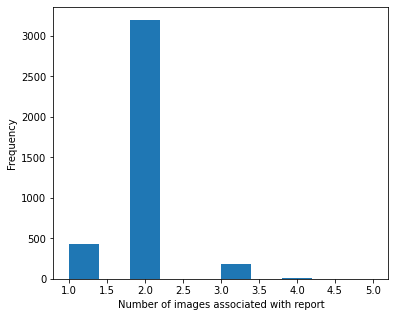

In [ ]:
img_count = list(full_df.uid.value_counts())

print("Images per patient :\n")
print(pd.Series(img_count).value_counts())


plt.figure(figsize = (6,5))
pd.Series(img_count).plot(kind='hist')
plt.xlabel('Number of images associated with report')
plt.ylabel("Frequency")
plt.show()

### 4. Plot some of x-ray images

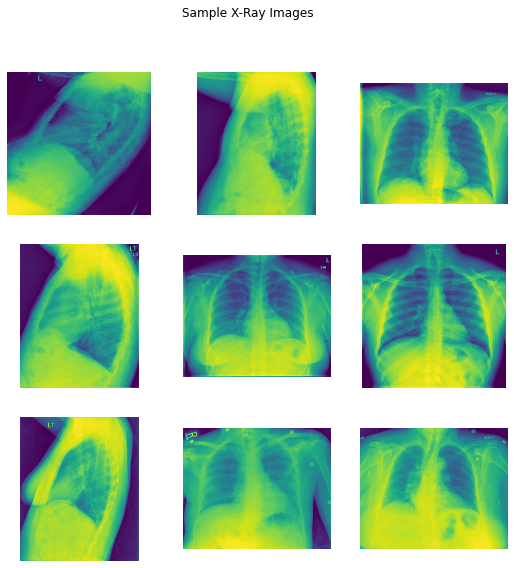

In [ ]:
fig = plt.figure(figsize=(9,9))
fig.suptitle('Sample X-Ray Images')

#Randomly select 9 x-ray image
path_files = list(full_df['filename'].sample(9))

for idx, img in enumerate(path_files):

    #Open the image
    root_dir = "/datasets/gdrive/XRay-AKAKI/images_normalized/"
    img_path = root_dir + img
    image = Image.open(img_path)
    
    #Plot the image
    plt.subplot(3,3,idx+1).imshow(image)
    plt.axis('off')

plt.show()

### 5. Plot x-ray images and their diagnoses

Below we show some sample images of the x-rays and the report for a given patient

In [ ]:
def show_image_captions(df, patient_nr):

    """
    Function to plot x-ray image and doctor's diagnoses
    """

    new_df = df[df["uid"] == patient_nr]
    print("Findings :",df['findings'][patient_nr])
    print("Impressions :",df['impression'][patient_nr])
    print("Caption :",df['caption'][patient_nr])
    
    root_dir = '/datasets/gdrive/XRay-AKAKI/images_normalized/'
    fig, axs = plt.subplots(1, len(new_df), figsize = (10,10), tight_layout=True)

    for i in range(len(new_df)):
        if new_df['filename'].iloc[i][:len(str(patient_nr))] == str(patient_nr):
            img_id = new_df['filename'].iloc[i]
            img_path = root_dir + img_id
            image = Image.open(img_path)
            imgplot = axs[i].imshow(image)

    plt.show()

Findings : borderline cardiomegaly. midline sternotomy. enlarged pulmonary arteries. clear lungs. inferior
Impressions : no acute pulmonary findings
Caption : borderline cardiomegaly. midline sternotomy. enlarged pulmonary arteries. clear lungs. inferior. no acute pulmonary findings


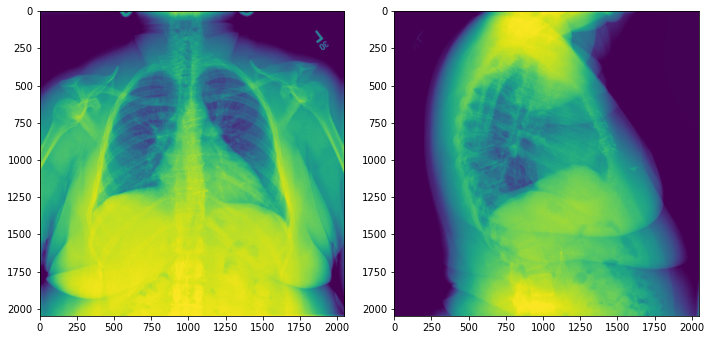

In [ ]:
show_image_captions(full_df, 2)

Findings : frontal and lateral views of the chest show an unchanged cardiomediastinal silhouette. no focal airspace consolidation or pleural effusion
Impressions : no acute or active cardiac pulmonary or pleural disease
Caption : frontal and lateral views of the chest show an unchanged cardiomediastinal silhouette. no focal airspace consolidation or pleural effusion. no acute or active cardiac pulmonary or pleural disease


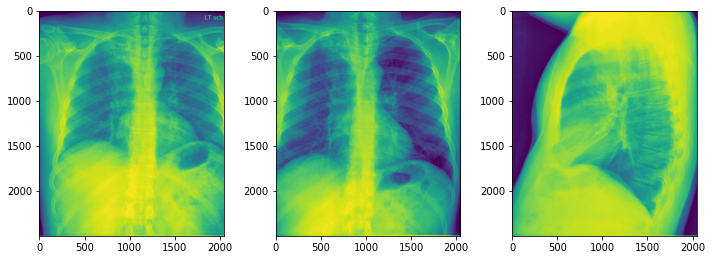

In [ ]:
show_image_captions(full_df, 1000)

### 6. Get average image for frontal and lateral views

To better understand how the X-ray images look, we generated the average image for frontal and lateral views; the process of extracting average images was adapted from Byeon (2020).

Reference: Eunjoo Byeon. (2020, September 11). Exploratory Data Analysis Ideas for Image Classification. Medium; Towards Data Science. Retrieved from https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

In [ ]:
def find_mean_img(full_mat, title, size = (64, 64)):

    #Calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

In [ ]:
#Load the frontal and lateral images numpy arrays
frontal_view = np.load("../data/image-data/frontal_images.npy")
lateral_view = np.load("../data/image-data/lateral_images.npy")

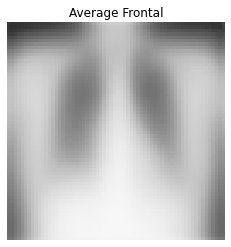

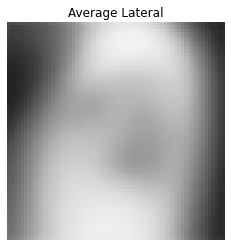

In [ ]:
#Plot the average images
frontal_mean = find_mean_img(frontal_view, 'Frontal')
lateral_mean = find_mean_img(lateral_view, 'Lateral')

### 7. Word Frequencies

Trying to understand the reports' content by generating wordclouds that are visual representations of words that appear more frequently.



In [ ]:
def generate_wordcloud(df,col_name):

    wordcloud = WordCloud(width=1600, height=800, 
                      max_words=500, background_color="black", 
                      colormap="Set3").generate(' '.join(df[col_name].astype(str)))

    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='Bilinear')
    plt.axis("off")
    plt.show()


#### Impression

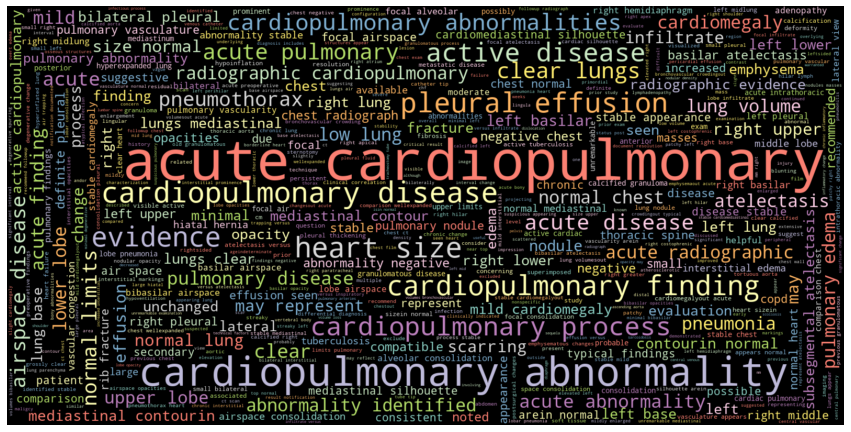

In [ ]:
generate_wordcloud(full_df,'impression')

#### Findings

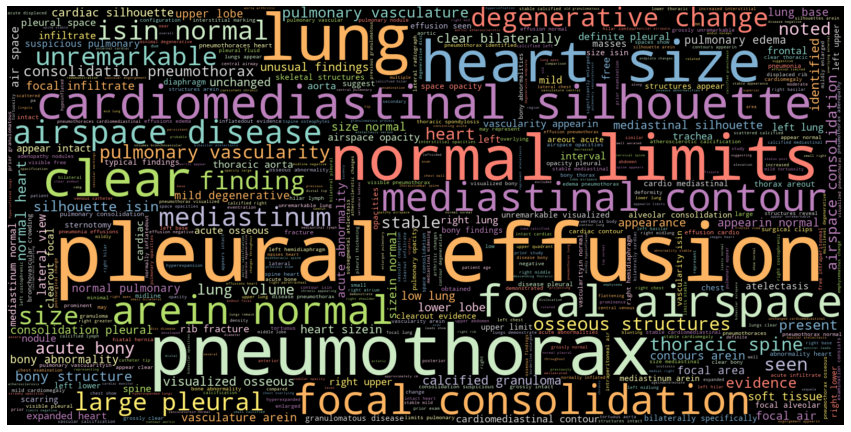

In [ ]:
generate_wordcloud(full_df,'findings')

#### Problems

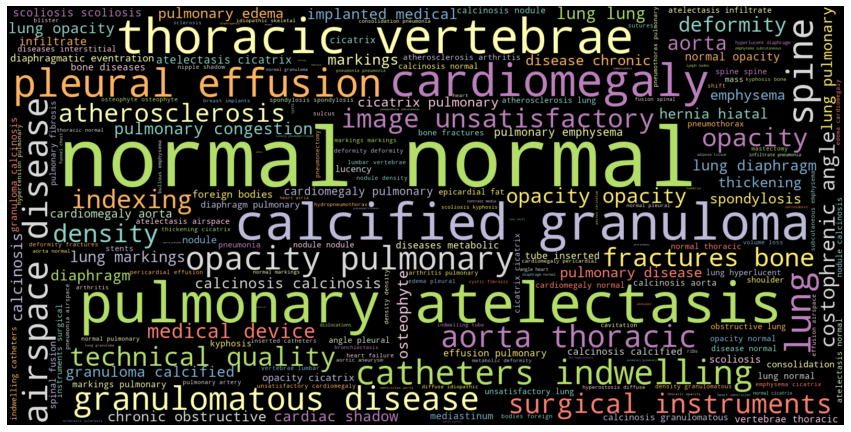

In [ ]:
generate_wordcloud(full_df,'Problems')

### 8. Length of reports

Getting a high-level understanding of how the reports look like. More specifically, we are looking at the length of the reports. 

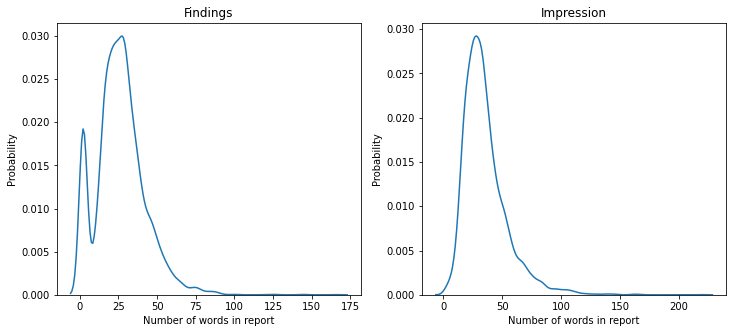

In [ ]:
get_report_num_word = lambda df, col: [len(txt.split()) for txt in df[col].values]

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
ax1.set_title('Findings')
sns.kdeplot(get_report_num_word(full_df,'findings'))
plt.ylabel('Probability')
plt.xlabel('Number of words in report')


ax2 = fig.add_subplot(122)
ax2.set_title('Impression')
sns.kdeplot(get_report_num_word(full_df,'impression'))
plt.ylabel('Probability')
plt.xlabel('Number of words in report')
plt.show()

- A majority of the reports for `findings` contain between 10-60 words, with a significant number containing less than 10
- A majority of the reports for `impression` contain less than 30 words, with a bulk containing less than 10

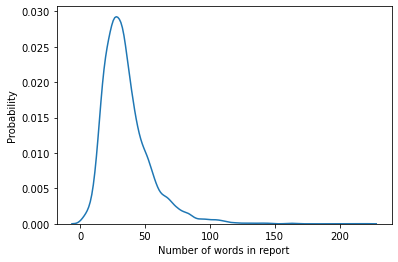

In [ ]:
ax = fig.add_subplot()
ax.set_title('Caption')
sns.kdeplot(get_report_num_word(full_df,'caption'))
plt.ylabel('Probability')
plt.xlabel('Number of words in report')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d67d5ca8-f99a-4baf-8748-4aa99efbd09b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>